# Projet TI : Steganographie de texte dans une image RVB

Projet réalisé par Baffert Ambre et Casino Lisa au cours de l'enseignement "Théorie de l'Information" donné par Mme Alexandrina Rogozan

## Première étape : Importations des librairies et affichage de l'image que nous allons utiliser

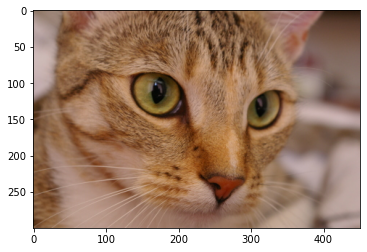

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2

img = skimage.data.chelsea()
plt.imshow(img)
plt.show()

In [2]:
print("Nombre de pixels sur Y :", img.shape[0])
print("Nombre de pixels sur X :", img.shape[1])
print("Image en couleur donc", img.shape[2],"pixels par pixel")

print("\nNombre de pixels total que l'on peut coder:", img.shape[0]*img.shape[1]*img.shape[2])

Nombre de pixels sur Y : 300
Nombre de pixels sur X : 451
Image en couleur donc 3 pixels par pixel

Nombre de pixels total que l'on peut coder: 405900


## Deuxième étape : Transformer chaque caractère du message en code ASCII puis binaire

In [3]:
message = "L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fument du cannabis. Ces chercheurs ont mené un essai avec quatre puissances de THC (0 %, 2,5 %, 6 % et 9,4 %) testées sur quatre périodes de 14 jours auprès de 23 personnes ayant des douleurs neuropathiques post-traumatiques ou post-chirurgicales. Résultat : ceux qui ont reçu du THC à 9,4 % se sont endormis plus facilement, plus vite, plus profondément, et la qualité de leur sommeil était la meilleure. Ils étaient moins anxieux et moins dépressifs que les autres. Côté effets secondaires, les plus fréquents étaient des maux de tête, une sécheresse des yeux, une sensation de brûlure dans des zones de douleur neuropathique, des évanouissements, des engourdissements et de la toux. Une euphorie a été notée 3 fois après la première dose d'un cycle, mais la quantité n'était pas suffisante pour induire l'effet recherché lors d'un usage récréatif, précisent les chercheurs dont les travaux ont été financés par les Canadian Institutes of Health Research. Ils recommandent de poursuivre les études"

In [4]:
def string_to_binaire(message):
    liste_de_binaire = []
    
    # On ajoute un mot-code STOP à la fin du message pour simplifier le décodage
    # Hint : STOP s'écrit en binaire : 01010011, 01010100, 01001111, 01010000
    STOP = ['01010011', '01010100', '01001111', '01010000','00101110']
    
    for lettre in message :
        lettre_asci = ord(lettre)
        lettre_binaire = bin(lettre_asci)
        lettre_binaire = lettre_binaire[2:].zfill(8)
        liste_de_binaire.append(lettre_binaire)
        
    return liste_de_binaire + STOP

liste_binaire = string_to_binaire(message)
    
def ligne_binaire(liste):
    ''' 
    fonction permettant d'obtenir à partir d'une liste de suite d'octet,
    une seule suite d'octet encodant l'intégralité du message 
    
    liste : le message sous forme de liste de caractères encodé en binaire 
    
    retourne le message écrit sous forme binaire avec des caractères encodés sur 8 bits '''
    
    chiffres = ""
    for i in liste:
        chiffres += i
        
    return chiffres

message_bin_flat = ligne_binaire(liste_binaire)

In [5]:
print("100 premiers bits du message :", message_bin_flat[:100])

100 premiers bits du message : 0100110000100111011001010110110101110000011011000110111101101001001000000110010001110101001000000110


In [6]:
len(message_bin_flat)

16000

In [7]:
(len(message_bin_flat)/405900)*100

3.9418576003941856

## Troisième étape : Création de la fonction qui génére des nombres pseudo aléatoires

In [8]:
import random

def generate_cle(coef, img):
    '''
    coef : le coefficient qui va être échangé entre personne A et personne B
    img : sert à avoir la taille de l'image càd le nombre de pixels pouvant être codé
    
    return : liste où chaque case correspond à un des pixels que nous allons encoder
    '''
    
    nbr_pixels = img.shape[0]*img.shape[1]*img.shape[2]
    MAX = nbr_pixels-1
    
    random.seed(coef)
    liste = [int(random.random()*nbr_pixels-1) for _ in range(MAX)]
    indexes = np.unique(liste, return_index=True)[1] # Avoir des pixels différents
    return [liste[index] for index in sorted(indexes)]

cle = generate_cle(23, img)

## Quatrième étape : Encoder l'image

lsb1, lsb2 et lsb3 correspondent au nombre de bits de poids faible que nous allons modifier.

In [9]:
lsb3 = 3
lsb2 = 2
lsb1 = 1

In [10]:
 def encoder_image(img, chiffres, lsb, cle):
    
    # étape 1 : flatten toute l'image
    # étape 2 : sur chaque pixel qui va être codé : 
         # on va créer un temp qui prend la valeur binaire de la nuance du pixel
         # on la modifie avec le nouveau message (1, 2 ou 3 nouveaux bits)
         # int(temp, 2) : de binaire à base 2
         # on remplace la valeur de l'image par le temp
    
    img_flat = img.flatten().copy()
    
    for case in cle[:(len(chiffres)//lsb)+1] :
        temp = bin(img_flat[case])[2:].zfill(8)
        #temp = temp.decode("utf-8")
        indice = 8-len(chiffres[0:lsb])
        temp_liste = list(temp)
        temp_liste[indice:] = chiffres[0:lsb]
        temp = ''.join(temp_liste)
        
        chiffres = chiffres[lsb:]
        
        temp = int(temp, 2)
        
        img_flat[case] = temp
    
    img_encoded = np.reshape(img_flat, img.shape)
        
    return img_encoded

img_encoded_lsb1 = encoder_image(img, message_bin_flat, lsb1, cle)
img_encoded_lsb2 = encoder_image(img, message_bin_flat, lsb2, cle)
img_encoded_lsb3 = encoder_image(img, message_bin_flat, lsb3, cle)

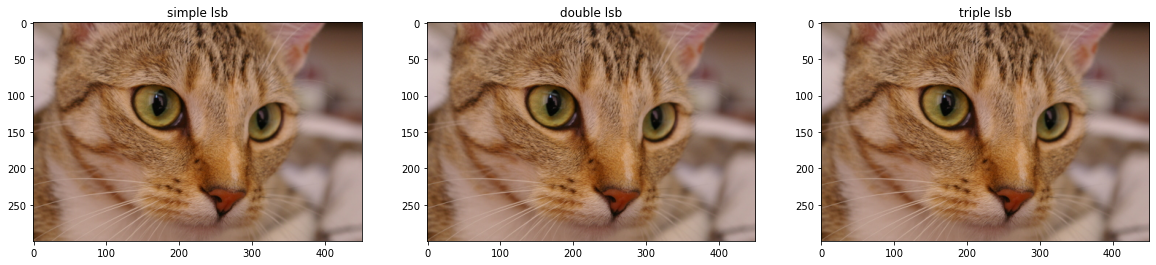

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title("simple lsb")
plt.imshow(img_encoded_lsb1)
plt.subplot(1,3,2)
plt.title("double lsb")
plt.imshow(img_encoded_lsb2)
plt.subplot(1,3,3)
plt.title("triple lsb")
plt.imshow(img_encoded_lsb3)

plt.show()

## Cinquième étape : Décoder le message

In [16]:
def find_secret_message(image_encoded, lsb, cle):

    # étape 1 : flatten l'image
    # étape 2 : pour chaque pixel de la liste "clé" :
        # on met en binaire
        # on récupère les 1, 2 ou 3 derniers bits (en fonction du lsb)
        # quand on a 8 bits : on stocke la variable (binaire) dans une liste (message_encoded_bin.append(bits))
        # quand on a 4 variables dans la liste : on regarde si ça fait le mot STOP
        # si oui : on arrête le de récupérer les bits
        
    img_flat = image_encoded.flatten().copy()
    i = 0
    message_encoded = []
    bits = ""
    motcode = ""
    
    while(True):
        temp = bin(img_flat[cle[i]])[2:].zfill(8)
        
        bits += temp[8-lsb:]
        
        if (len(bits) >= 8):
            if (len(bits) > 8):
                bits_8 = bits[:8]
                bits_reste = bits[8:]
            else:
                bits_8 = bits
                bits_reste = ""
                
            message_encoded.append(chr(int(bits_8,2)))
            
            # A partir de 4 lettres, on peut penser qu'il y a le mot-code STOP
            # On récupère donc ces 4 dernières lettres et on regarde si c'est STOP
            # Si c'est le cas : on arrête la recherche de binaire
            if(len(message_encoded)>=4):
                maximum = len(message_encoded)
                motcode = message_encoded[maximum-4:maximum]
                
                # On enlève les 4 lettres binaires à la fin du message recupéré
                if(motcode == ['S','T','O','P']):
                    message_encoded = message_encoded[:maximum-4]
                    break;
            
            bits = bits_reste
            
        i += 1
        
    return (''.join(message_encoded))

secret_message_lsb1 = find_secret_message(img_encoded_lsb1, lsb1, cle)
secret_message_lsb2 = find_secret_message(img_encoded_lsb2, lsb2, cle)
secret_message_lsb3 = find_secret_message(img_encoded_lsb3, lsb3, cle)

In [17]:
print(secret_message_lsb1)

L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fume

In [18]:
print(secret_message_lsb2)

L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fume

In [19]:
print(secret_message_lsb3)

L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fume

## Comparons visuellement les deux images

In [20]:
def histogramme(image, titre):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([image],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.xlabel('Valeurs')
    plt.ylabel('Nombre de pixels')
    plt.title(titre)

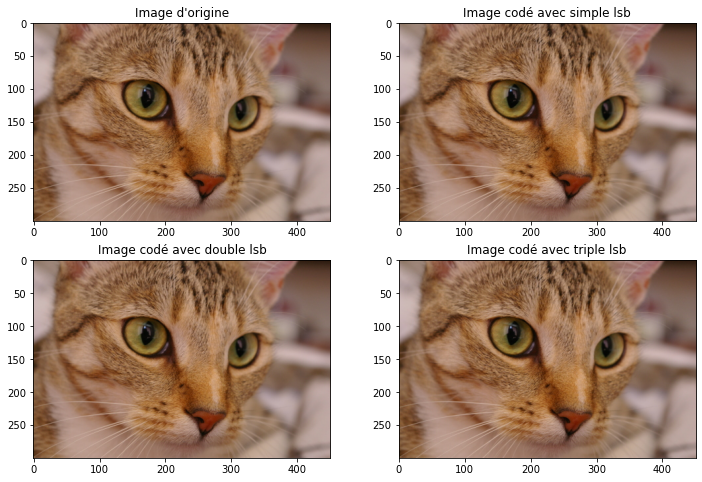

In [21]:
plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.title("Image d'origine")
plt.imshow(img)
plt.subplot(2,2,2)
plt.title("Image codé avec simple lsb")
plt.imshow(img_encoded_lsb1)
plt.subplot(2,2,3)
plt.title("Image codé avec double lsb")
plt.imshow(img_encoded_lsb2)
plt.subplot(2,2,4)
plt.title("Image codé avec triple lsb")
plt.imshow(img_encoded_lsb3)
plt.show()

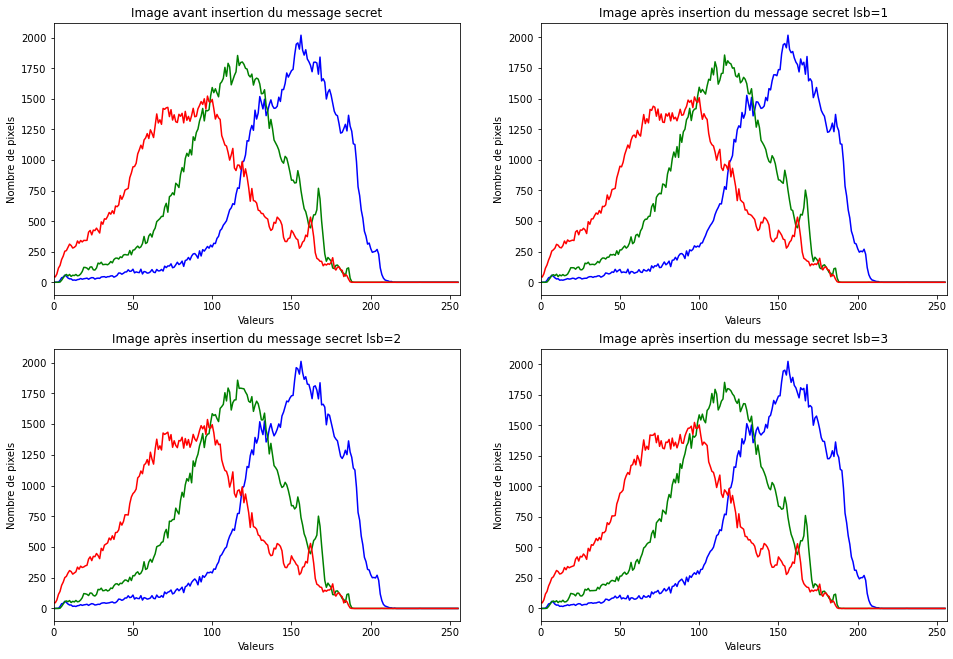

In [22]:
plt.figure(figsize=(16,11))
plt.subplot(2,2,1)
histogramme(img, "Image avant insertion du message secret")
plt.subplot(2,2,2)
histogramme(img_encoded_lsb1, "Image après insertion du message secret lsb=1")
plt.subplot(2,2,3)
histogramme(img_encoded_lsb2, "Image après insertion du message secret lsb=2")
plt.subplot(2,2,4)
histogramme(img_encoded_lsb3, "Image après insertion du message secret lsb=3")

## Comparons nous résultats avec un message plus long

In [23]:
message_long = "L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fument du cannabis. Ces chercheurs ont mené un essai avec quatre puissances de THC (0 %, 2,5 %, 6 % et 9,4 %) testées sur quatre périodes de 14 jours auprès de 23 personnes ayant des douleurs neuropathiques post-traumatiques ou post-chirurgicales. Résultat : ceux qui ont reçu du THC à 9,4 % se sont endormis plus facilement, plus vite, plus profondément, et la qualité de leur sommeil était la meilleure. Ils étaient moins anxieux et moins dépressifs que les autres. Côté effets secondaires, les plus fréquents étaient des maux de tête, une sécheresse des yeux, une sensation de brûlure dans des zones de douleur neuropathique, des évanouissements, des engourdissements et de la toux. Une euphorie a été notée 3 fois après la première dose d'un cycle, mais la quantité n'était pas suffisante pour induire l'effet recherché lors d'un usage récréatif, précisent les chercheurs dont les travaux ont été financés par les Canadian Institutes of Health Research. Ils recommandent de poursuivre les études. L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fument du cannabis. Ces chercheurs ont mené un essai avec quatre puissances de THC (0 %, 2,5 %, 6 % et 9,4 %) testées sur quatre périodes de 14 jours auprès de 23 personnes ayant des douleurs neuropathiques post-traumatiques ou post-chirurgicales. Résultat : ceux qui ont reçu du THC à 9,4 % se sont endormis plus facilement, plus vite, plus profondément, et la qualité de leur sommeil était la meilleure. Ils étaient moins anxieux et moins dépressifs que les autres. Côté effets secondaires, les plus fréquents étaient des maux de tête, une sécheresse des yeux, une sensation de brûlure dans des zones de douleur neuropathique, des évanouissements, des engourdissements et de la toux. Une euphorie a été notée 3 fois après la première dose d'un cycle, mais la quantité n'était pas suffisante pour induire l'effet recherché lors d'un usage récréatif, précisent les chercheurs dont les travaux ont été financés par les Canadian Institutes of Health Research. Ils recommandent de poursuivre les études. L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fument du cannabis. Ces chercheurs ont mené un essai avec quatre puissances de THC (0 %, 2,5 %, 6 % et 9,4 %) testées sur quatre périodes de 14 jours auprès de 23 personnes ayant des douleurs neuropathiques post-traumatiques ou post-chirurgicales. Résultat : ceux qui ont reçu du THC à 9,4 % se sont endormis plus facilement, plus vite, plus profondément, et la qualité de leur sommeil était la meilleure. Ils étaient moins anxieux et moins dépressifs que les autres. Côté effets secondaires, les plus fréquents étaient des maux de tête, une sécheresse des yeux, une sensation de brûlure dans des zones de douleur neuropathique, des évanouissements, des engourdissements et de la toux. Une euphorie a été notée 3 fois après la première dose d'un cycle, mais la quantité n'était pas suffisante pour induire l'effet recherché lors d'un usage récréatif, précisent les chercheurs dont les travaux ont été financés par les Canadian Institutes of Health Research. Ils recommandent de poursuivre les études. L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fument du cannabis. Ces chercheurs ont mené un essai avec quatre puissances de THC (0 %, 2,5 %, 6 % et 9,4 %) testées sur quatre périodes de 14 jours auprès de 23 personnes ayant des douleurs neuropathiques post-traumatiques ou post-chirurgicales. Résultat : ceux qui ont reçu du THC à 9,4 % se sont endormis plus facilement, plus vite, plus profondément, et la qualité de leur sommeil était la meilleure. Ils étaient moins anxieux et moins dépressifs que les autres. Côté effets secondaires, les plus fréquents étaient des maux de tête, une sécheresse des yeux, une sensation de brûlure dans des zones de douleur neuropathique, des évanouissements, des engourdissements et de la toux. Une euphorie a été notée 3 fois après la première dose d'un cycle, mais la quantité n'était pas suffisante pour induire l'effet recherché lors d'un usage récréatif, précisent les chercheurs dont les travaux ont été financés par les Canadian Institutes of Health Research. Ils recommandent de poursuivre les études. L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fument du cannabis. Ces chercheurs ont mené un essai avec quatre puissances de THC (0 %, 2,5 %, 6 % et 9,4 %) testées sur quatre périodes de 14 jours auprès de 23 personnes ayant des douleurs neuropathiques post-traumatiques ou post-chirurgicales. Résultat : ceux qui ont reçu du THC à 9,4 % se sont endormis plus facilement, plus vite, plus profondément, et la qualité de leur sommeil était la meilleure. Ils étaient moins anxieux et moins dépressifs que les autres. Côté effets secondaires, les plus fréquents étaient des maux de tête, une sécheresse des yeux, une sensation de brûlure dans des zones de douleur neuropathique, des évanouissements, des engourdissements et de la toux. Une euphorie a été notée 3 fois après la première dose d'un cycle, mais la quantité n'était pas suffisante pour induire l'effet recherché lors d'un usage récréatif, précisent les chercheurs dont les travaux ont été financés par les Canadian Institutes of Health Research. Ils recommandent de poursuivre les études. L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fument du cannabis. Ces chercheurs ont mené un essai avec quatre puissances de THC (0 %, 2,5 %, 6 % et 9,4 %) testées sur quatre périodes de 14 jours auprès de 23 personnes ayant des douleurs neuropathiques post-traumatiques ou post-chirurgicales. Résultat : ceux qui ont reçu du THC à 9,4 % se sont endormis plus facilement, plus vite, plus profondément, et la qualité de leur sommeil était la meilleure. Ils étaient moins anxieux et moins dépressifs que les autres. Côté effets secondaires, les plus fréquents étaient des maux de tête, une sécheresse des yeux, une sensation de brûlure dans des zones de douleur neuropathique, des évanouissements, des engourdissements et de la toux. Une euphorie a été notée 3 fois après la première dose d'un cycle, mais la quantité n'était pas suffisante pour induire l'effet recherché lors d'un usage récréatif, précisent les chercheurs dont les travaux ont été financés par les Canadian Institutes of Health Research. Ils recommandent de poursuivre les études. L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fument du cannabis. Ces chercheurs ont mené un essai avec quatre puissances de THC (0 %, 2,5 %, 6 % et 9,4 %) testées sur quatre périodes de 14 jours auprès de 23 personnes ayant des douleurs neuropathiques post-traumatiques ou post-chirurgicales. Résultat : ceux qui ont reçu du THC à 9,4 % se sont endormis plus facilement, plus vite, plus profondément, et la qualité de leur sommeil était la meilleure. Ils étaient moins anxieux et moins dépressifs que les autres. Côté effets secondaires, les plus fréquents étaient des maux de tête, une sécheresse des yeux, une sensation de brûlure dans des zones de douleur neuropathique, des évanouissements, des engourdissements et de la toux. Une euphorie a été notée 3 fois après la première dose d'un cycle, mais la quantité n'était pas suffisante pour induire l'effet recherché lors d'un usage récréatif, précisent les chercheurs dont les travaux ont été financés par les Canadian Institutes of Health Research. Ils recommandent de poursuivre les études"

In [24]:
liste_binaire = string_to_binaire(message_long)
message_bin_flat = ligne_binaire(liste_binaire)
print("le message est encodé sur ",(len(message_bin_flat)/405900)*100,"% de l'image")



le message est encodé sur  27.557526484355755 % de l'image


In [26]:
cle = generate_cle(23, img)
img_encoded_lsb1 = encoder_image(img, message_bin_flat, lsb1, cle)
img_encoded_lsb2 = encoder_image(img, message_bin_flat, lsb2, cle)
img_encoded_lsb3 = encoder_image(img, message_bin_flat, lsb3, cle)

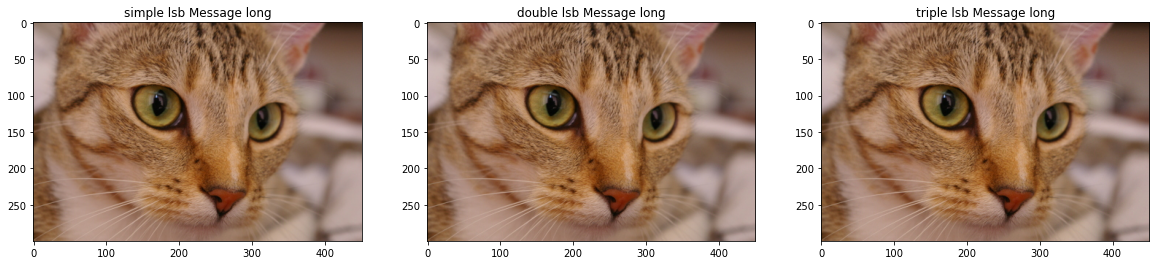

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title("simple lsb Message long")
plt.imshow(img_encoded_lsb1)
plt.subplot(1,3,2)
plt.title("double lsb Message long")
plt.imshow(img_encoded_lsb2)
plt.subplot(1,3,3)
plt.title("triple lsb Message long")
plt.imshow(img_encoded_lsb3)

plt.show()

In [28]:
secret_message_lsb1 = find_secret_message(img_encoded_lsb1, lsb1, cle)
secret_message_lsb2 = find_secret_message(img_encoded_lsb2, lsb2, cle)
secret_message_lsb3 = find_secret_message(img_encoded_lsb3, lsb3, cle)

In [34]:
print("message original == message lsb 1 :",message_long == secret_message_lsb1)
print("message original == message lsb 2 :",message_long == secret_message_lsb2)
print("message original == message lsb 3 :",message_long == secret_message_lsb3)

message original == message lsb 1 : True
message original == message lsb 2 : True
message original == message lsb 3 : True


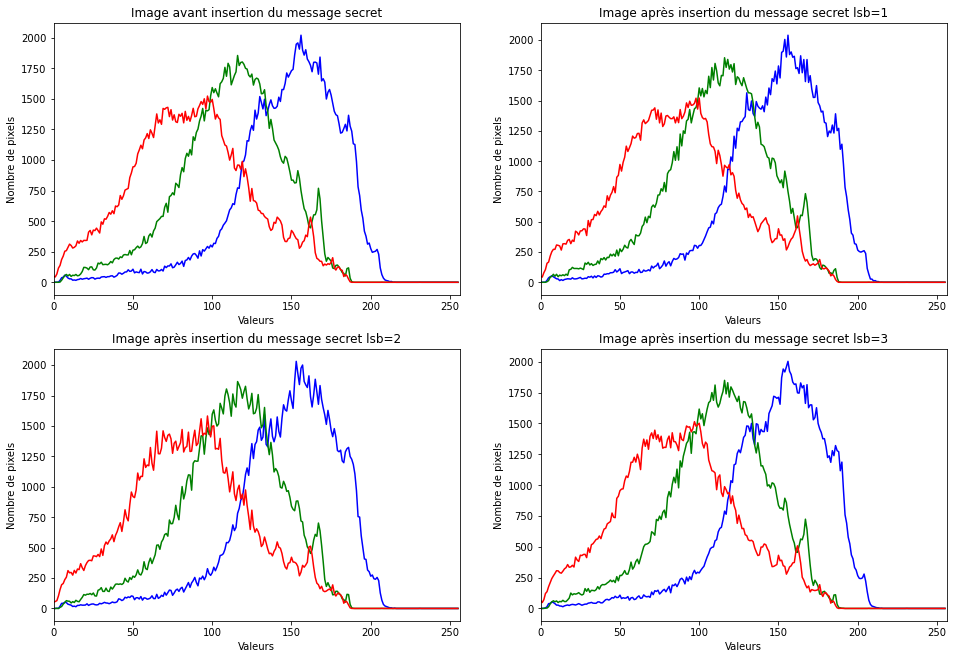

In [31]:
plt.figure(figsize=(16,11))
plt.subplot(2,2,1)
histogramme(img, "Image avant insertion du message secret")
plt.subplot(2,2,2)
histogramme(img_encoded_lsb1, "Image après insertion du message secret lsb=1")
plt.subplot(2,2,3)
histogramme(img_encoded_lsb2, "Image après insertion du message secret lsb=2")
plt.subplot(2,2,4)
histogramme(img_encoded_lsb3, "Image après insertion du message secret lsb=3")